# AMC Reveiws Sentiment Classification
The purpose of this project is to use a DNN to classify the sentiments of reviews on movies, TV series, etc.

In [57]:
import numpy as np
import pandas as pd
import matplotlib as plt
from IPython.display import Image
from collections import Counter
from bokeh.models import ColumnDataSource, LabelSet
from sklearn.manifold import TSNE
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, output_file

output_notebook()

Loading BokehJS ...

## Load & Prepare Data

In [2]:
# Load the review fils and labels
with open('reviews.txt', 'r') as file:
    data = list(map(lambda x:x[:-1],file.readlines()))

with open('labels.txt', 'r') as file:
    labels = list(map(lambda x:x[:-1].upper(),file.readlines()))

In [3]:
print("There are ",len(data),"lines of reviews in our data set. Let's look at the first 2 reviews:")
DataSetFrame = pd.DataFrame(labels,data)
DataSetFrame.head(2)

There are  25000 lines of reviews in our data set. Let's look at the first 2 reviews:


,0
bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life such as teachers . my years in the teaching profession lead me to believe that bromwell high s satire is much closer to reality than is teachers . the scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn t,POSITIVE
story of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is turned into an insane violent mob by the crazy chantings of it s singers . unfortunately it stays absurd the whole time with no general narrative eventually making it just too off putting . even those from the era should be turned off . the cryptic dialogue would make shakespeare seem easy to a third grader . on a technical level it s better than you might think with some good cinematography by future great vilmos zsigmond . future stars sally kirkland and frederic forrest can be seen briefly .,NEGATIVE


# Data Investigation
### How can we make a corelation between the reviews and the labels? 
Let's take a look at few of our data set

In [4]:
for i in range(7):
    print(labels[i]+':\t'+data[i][:90]+'...')

POSITIVE:	bromwell high is a cartoon comedy . it ran at the same time as some other programs about s...
NEGATIVE:	story of a man who has unnatural feelings for a pig . starts out with a opening scene that...
POSITIVE:	homelessness  or houselessness as george carlin stated  has been an issue for years but ne...
NEGATIVE:	airport    starts as a brand new luxury    plane is loaded up with valuable paintings  suc...
POSITIVE:	brilliant over  acting by lesley ann warren . best dramatic hobo lady i have ever seen  an...
NEGATIVE:	this film lacked something i couldn  t put my finger on at first charisma on the part of t...
POSITIVE:	this is easily the most underrated film inn the brooks cannon . sure  its flawed . it does...


We would like to see how many times each word is repeated in our vocabulary set. This will give us some idea about the most repeated words and also noisy words that don't carry any hint to the feedback received.
We also would like to what are the most common words in each set of *NEGATIVE* or *POSITIVE* feedback categories. 

In [27]:
positive_label_count = Counter()
negative_label_count = Counter()
total_count = Counter()

for i in range(len(data)):
    if(labels[i] == 'POSITIVE'):
        for word in data[i].split(' '):
            positive_label_count[word] += 1
            total_count[word] += 1
    else:
        for word in data[i].split(' '):
            negative_label_count[word] += 1
            total_count[word] += 1


In [28]:
print("Total number of vocabularies: ", len(total_count))

Total number of vocabularies:  74074


In [8]:
print('There are ',len(negative_label_count),'words in the negetive reviews colloction')

There are  53635 words in the negetive reviews colloction


In [9]:
print('There are ',len(positive_label_count), 'words in the positive reviews collection')

There are  55214 words in the positive reviews collection


In [10]:
print('30 Most common words in positive: ')
print(list(positive_label_count.most_common())[:30])

30 Most common words in positive: 
[('', 550468), ('the', 173324), ('.', 159654), ('and', 89722), ('a', 83688), ('of', 76855), ('to', 66746), ('is', 57245), ('in', 50215), ('br', 49235), ('it', 48025), ('i', 40743), ('that', 35630), ('this', 35080), ('s', 33815), ('as', 26308), ('with', 23247), ('for', 22416), ('was', 21917), ('film', 20937), ('but', 20822), ('movie', 19074), ('his', 17227), ('on', 17008), ('you', 16681), ('he', 16282), ('are', 14807), ('not', 14272), ('t', 13720), ('one', 13655)]


In [11]:
print('30 Most common words in negative: ')
print(list(negative_label_count.most_common())[:30])

30 Most common words in negative: 
[('', 561462), ('.', 167538), ('the', 163389), ('a', 79321), ('and', 74385), ('of', 69009), ('to', 68974), ('br', 52637), ('is', 50083), ('it', 48327), ('i', 46880), ('in', 43753), ('this', 40920), ('that', 37615), ('s', 31546), ('was', 26291), ('movie', 24965), ('for', 21927), ('but', 21781), ('with', 20878), ('as', 20625), ('t', 20361), ('film', 19218), ('you', 17549), ('on', 17192), ('not', 16354), ('have', 15144), ('are', 14623), ('be', 14541), ('he', 13856)]


There are also so many common words in both collections of negetive and postive reviews, such as 'the' and 'to'. Words that are used more frequently in one collection over the other, can be more informative to our network.

I am curious to see what words are in one category that do not exists on the other one. 

In [12]:
print(list((negative_label_count - positive_label_count).most_common())[5:25])

[('this', 5840), ('bad', 5494), ('was', 4374), ('no', 3569), ('just', 3467), ('br', 3402), ('they', 3116), ('even', 2723), ('there', 2718), ('have', 2557), ('or', 2540), ('so', 2309), ('if', 2233), ('to', 2228), ('worst', 2228), ('like', 2200), ('be', 2125), ('not', 2082), ('that', 1985), ('don', 1868)]


In [13]:
print(list((positive_label_count - negative_label_count).most_common())[5:25])

[('as', 5683), ('his', 5080), ('a', 4367), ('great', 3779), ('very', 2541), ('her', 2527), ('he', 2426), ('with', 2369), ('s', 2269), ('best', 2225), ('well', 2151), ('love', 2149), ('also', 1942), ('life', 1770), ('film', 1719), ('has', 1582), ('story', 1572), ('who', 1495), ('by', 1448), ('she', 1335)]


It is obvious that words like 'bad' and 'worst' are among the most common words of negatvie labels, excluded in positive reviews. On the other hand, words like 'well' and 'great' are exculded from negetive reviews, but among most common words of positive reviews. But still I don't think our network can use any of these information during trainig. Next idea to try is to see whether, the ratio of words in two categories have any meaning or hint toward the feedback.


In [14]:
pos_neg_ratios = Counter()
for word,cnt in positive_label_count.most_common():
    if (cnt > 100):
        pos_neg_ratios[word] += positive_label_count[word]/(negative_label_count[word]+1)

In [15]:
print("Pos-to-neg ratio for 'the' = {}".format(pos_neg_ratios["the"]))
print("Pos-to-neg ratio for 'amazing' = {}".format(pos_neg_ratios["amazing"]))
print("Pos-to-neg ratio for 'terrible' = {}".format(pos_neg_ratios["terrible"]))
print("Pos-to-neg ratio for 'awful' = {}".format(pos_neg_ratios["awful"]))
print("Pos-to-neg ratio for 'and' = {}".format(pos_neg_ratios["and"]))

Pos-to-neg ratio for 'the' = 1.0607993145235326
Pos-to-neg ratio for 'amazing' = 4.022813688212928
Pos-to-neg ratio for 'terrible' = 0.17744252873563218
Pos-to-neg ratio for 'awful' = 0.10783055198973042
Pos-to-neg ratio for 'and' = 1.2061678272793268


In [16]:
pos_neg_ratios_log = Counter()

for word,ratio in pos_neg_ratios.most_common():
    if ratio > 1:
        pos_neg_ratios_log[word] += np.log(pos_neg_ratios[word])
    else:
        pos_neg_ratios_log[word] += (-np.log(1/(pos_neg_ratios[word]+0.01)))

In [17]:
print("Pos-to-neg ratio for 'the' = {}".format(pos_neg_ratios_log["the"]))
print("Pos-to-neg ratio for 'amazing' = {}".format(pos_neg_ratios_log["amazing"]))
print("Pos-to-neg ratio for 'terrible' = {}".format(pos_neg_ratios_log["terrible"]))
print("Pos-to-neg ratio for 'awful' = {}".format(pos_neg_ratios_log["awful"]))
print("Pos-to-neg ratio for 'and' = {}".format(pos_neg_ratios_log["and"]))

Pos-to-neg ratio for 'the' = 0.05902269426102881
Pos-to-neg ratio for 'amazing' = 1.3919815802404802
Pos-to-neg ratio for 'terrible' = -1.6742829939664696
Pos-to-neg ratio for 'awful' = -2.1385076866397488
Pos-to-neg ratio for 'and' = 0.18744824888788403


Now words with positive and over 1.0 ratio are definitly carrying more postive sentiment and neutrials are the one with ratio more closely to 0.0. Negetive ratios are more accured in our negetive collections , therefore they are carrying more negetive sentiment.

In [35]:
list(reversed(pos_neg_ratios_log.most_common()[0:15]))

[('powell', 1.9783454248084671),
 ('wonderfully', 2.0218960560332353),
 ('captures', 2.0386195471595809),
 ('astaire', 2.1400661634962708),
 ('perfection', 2.1594842493533721),
 ('superbly', 2.2600254785752498),
 ('flawless', 2.451005098112319),
 ('gandhi', 2.5389738710582761),
 ('mildred', 2.6026896854443837),
 ('victoria', 2.6810215287142909),
 ('matthau', 2.8067217286092401),
 ('polanski', 2.8233610476132043),
 ('felix', 3.1527360223636558),
 ('paulie', 4.0775374439057197),
 ('edie', 4.6913478822291435)]

Words like 'superbly', 'flawless' have a higher positive ratio in the list. However, we still need to reduce the noise from our data.

### Reducing Noise by Strategically Reducing the Vocabulary

In order to reduce the noise, only words that have been repeated more than 50 times are included in training data set. Words that have a nutrial corelation to the feedbacks, are also removed from training set, by addind a polaroty cutoff threshold to the data set.

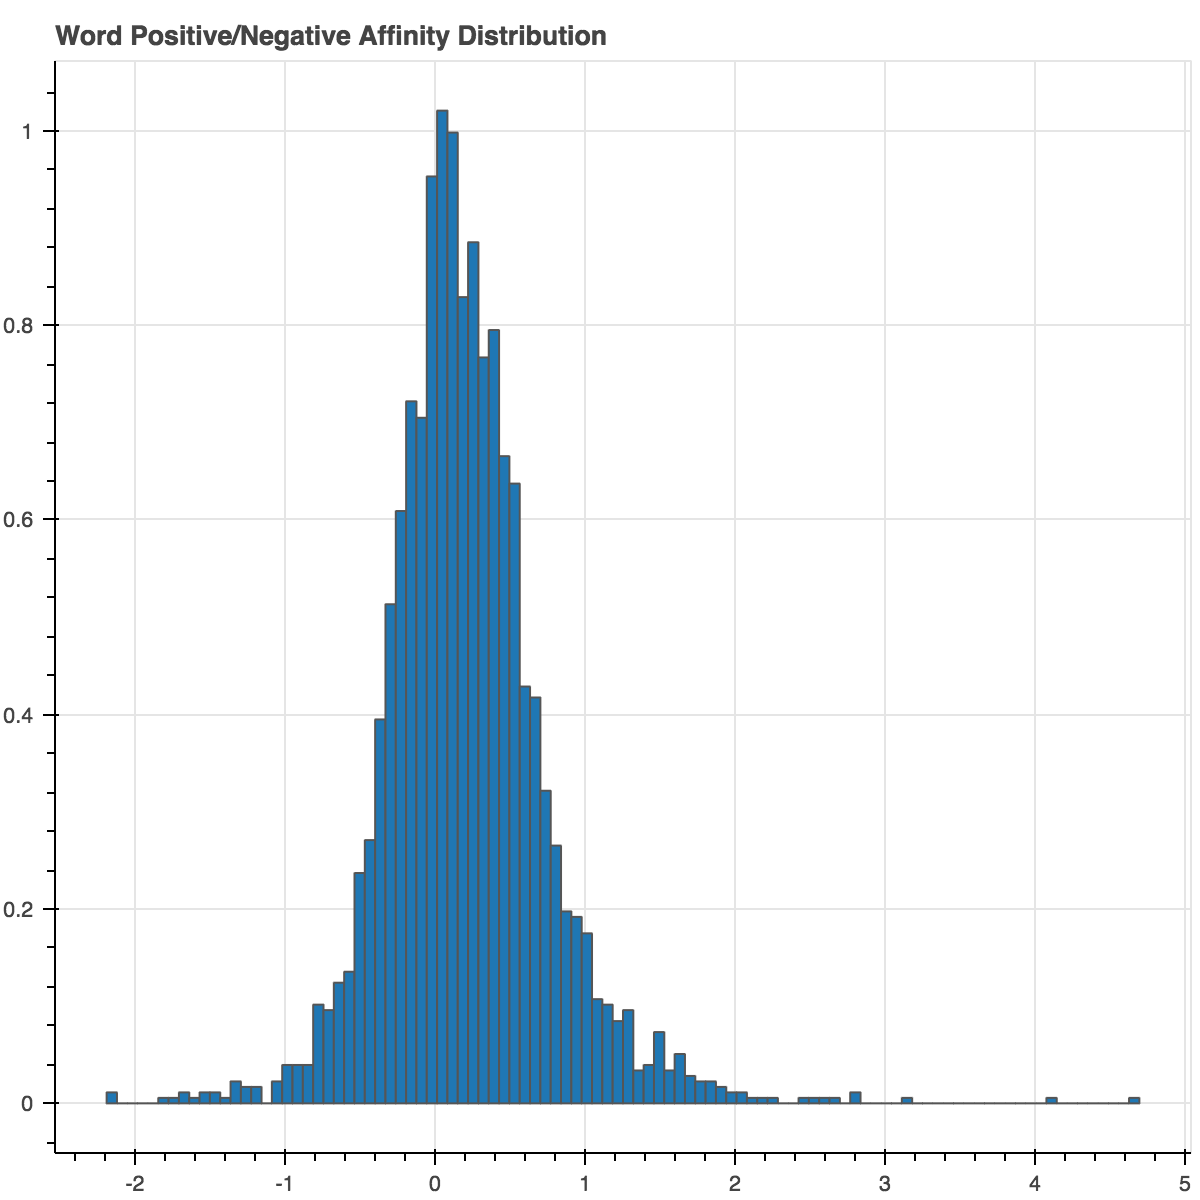

In [58]:
hist, edges = np.histogram(list(map(lambda x:x[1],pos_neg_ratios_log.most_common())),density=True, bins=100, normed=True)
output_file('output.html')
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="Word Positive/Negative Affinity Distribution")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555")
# show(p)

Image(filename='bokeh_plot.png')


In [32]:
freq_freq = Counter()

for word, count in total_count.most_common():
    freq_freq[count] += 1

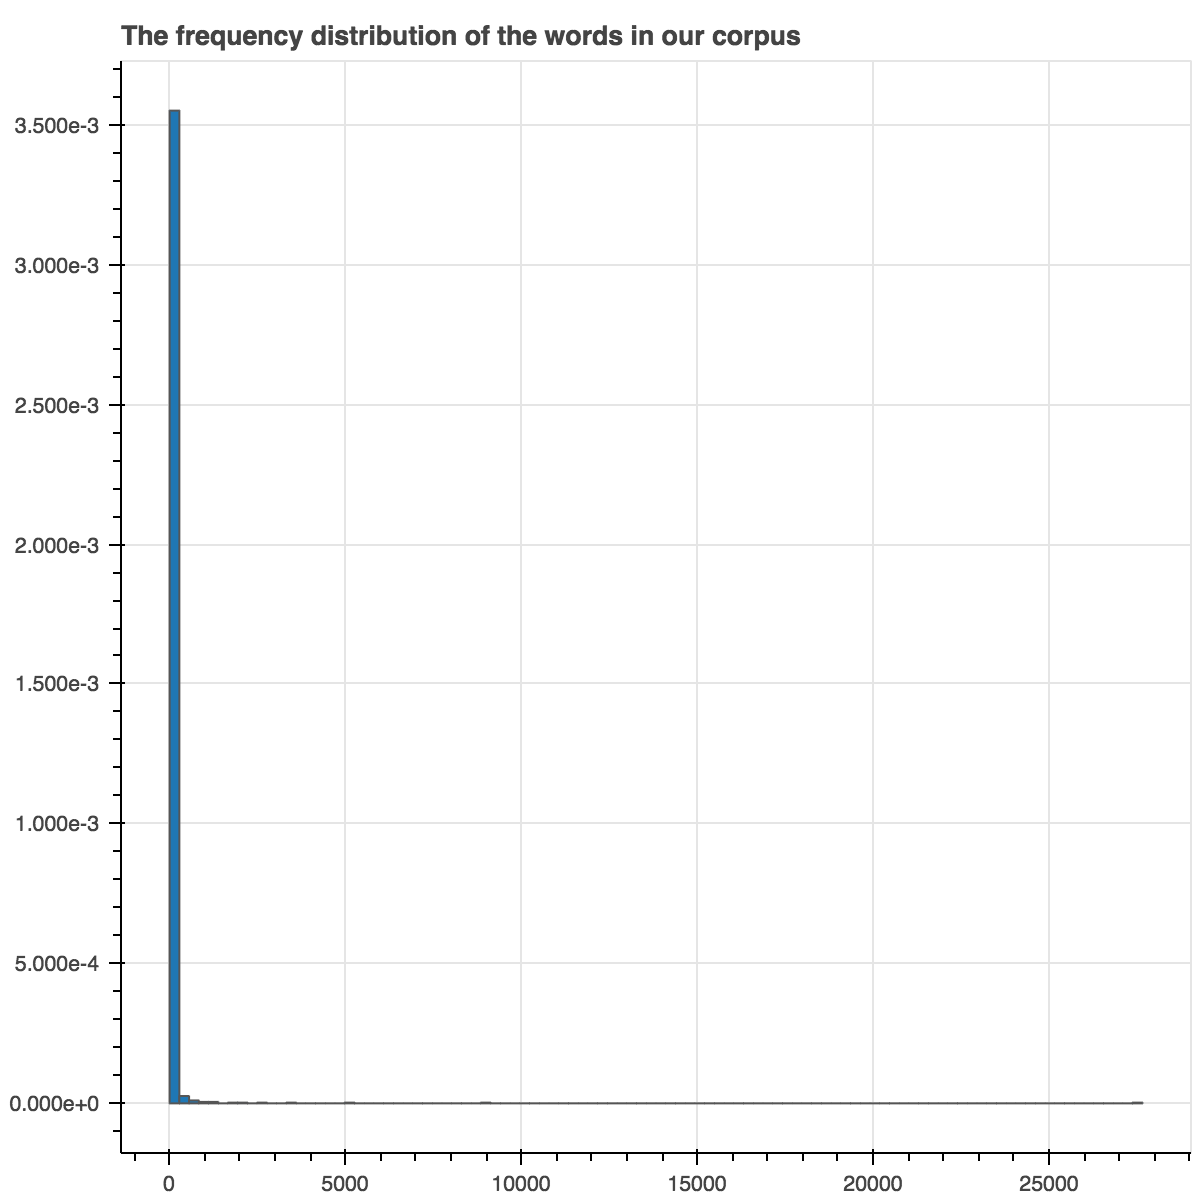

In [69]:
hist, edges = np.histogram(list(map(lambda x:x[1],freq_freq.most_common())),density=True, bins=100, normed=True)
# output_file('output.html')
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="The frequency distribution of the words in our corpus")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555")
# show(p)

Image(filename='histo3.png')

## Building the Neural Net


In [36]:
vocabulary_set = set(total_count)
vocab_size = len(vocabulary_set)

In [37]:
print('We have total of ',vocab_size, 'unique words in our data set')

We have total of  74074 unique words in our data set


In [38]:
layer_0 = np.zeros(shape=(1,vocab_size))

In [39]:
layer_0.shape

(1, 74074)

In [40]:
word_to_count = {}
for i,words in enumerate(vocabulary_set):
    word_to_count[words] = i


### Neural Network

In [41]:
import time
import sys
import numpy as np

# Encapsulate our neural network in a class
class SentimentNetwork:
    def __init__(self, reviews, labels, hidden_nodes = 10, min_count=10, polarity_cutoff=0.1, learning_rate=0.1):
        """Create a SentimenNetwork with the given settings
        Args:
            reviews(list) - List of reviews used for training
            labels(list) - List of POSITIVE/NEGATIVE labels associated with the given reviews
            hidden_nodes(int) - Number of nodes to create in the hidden layer
            learning_rate(float) - Learning rate to use while training
            min_count(int) - threshold of word count in training set
            polarity_cutoff(float) - The ratio of word occurance in negative to positive categories
        
        """
        np.random.seed(1)
        self.pre_process_data(reviews, labels, min_count, polarity_cutoff)
        self.init_network(len(self.review_vocab),hidden_nodes, 1, learning_rate)

    def pre_process_data(self, reviews, labels, min_count, polarity_cutoff):
        
        positive_label_count = Counter()
        negative_label_count = Counter()
        total_count = Counter()

        for i in range(len(reviews)):
            if(labels[i] == 'POSITIVE'):
                for word in reviews[i].split(' '):
                    positive_label_count[word] += 1
                    total_count[word] += 1
            else:
                for word in reviews[i].split(' '):
                    negative_label_count[word] += 1
                    total_count[word] += 1
        
        pos_neg_ratios = Counter()
        
        for word,cnt in total_count.most_common():
            if (cnt >= 50):
                pos_neg_ratios[word] = positive_label_count[word]/float(negative_label_count[word]+1)
        
        for words,ratio in pos_neg_ratios.most_common():
            if ratio > 1:
                pos_neg_ratios[word] = np.log(ratio)
            else:
                pos_neg_ratios[word] = (-np.log(1/(ratio+0.01)))
        
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                if (total_count[word] >= min_count):
                    if (word in pos_neg_ratios.keys()):
                        if (abs(pos_neg_ratios[word]) >= polarity_cutoff):
                            review_vocab.add(word)
                    else:
                        review_vocab.add(word)
            
        
        # Convert the vocabulary set to a list so we can access words via indices
        self.review_vocab = list(review_vocab)
        
        label_vocab = set()
        for label in labels:
            label_vocab.update(label.upper())
        # Convert the label vocabulary set to a list so we can access labels via indices
        self.label_vocab = list(label_vocab)
        
        # Store the sizes of the review and label vocabularies.
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        # Create a dictionary of words in the vocabulary mapped to index positions
        self.word2index = {}
        for i,word in enumerate(self.review_vocab):
            self.word2index[word] = i
            
        
        # Create a dictionary of labels mapped to index positions
        self.label2index = {}
        for i,label in enumerate(self.label_vocab):
            self.label2index[label] = i

                
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Store the number of nodes in input, hidden, and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Store the learning rate
        self.learning_rate = learning_rate

        # Initialize weights
        self.weights_0_1 = np.zeros((self.input_nodes,self.hidden_nodes))

        self.weights_1_2 = np.random.normal(0.0,self.output_nodes**-0.5,
                                            (self.hidden_nodes, self.output_nodes))

        self.layer_1 = np.zeros((1,hidden_nodes))
                
    def get_target_for_label(self,label):
        if (label == 'POSITIVE'):
            return 1
        else:
            return 0
        
    def sigmoid(self,x):
        return (1 /(1 + np.exp(-x)))
    
    def sigmoid_output_2_derivative(self,output):
        return output * (1 - output)

    def train(self, training_reviews_raw, training_labels):
        
        training_reviews = []
        for review in training_reviews_raw:
            indices = set()
            for word in review.split(" "):
                if (word in self.word2index.keys()):
                    indices.add(self.word2index[word])
            training_reviews.append(list(indices))
#         print(len(training_reviews[0])) 
        # make sure out we have a matching number of reviews and labels
        assert(len(training_reviews) == len(training_labels))
        
        # Keep track of correct predictions to display accuracy during training 
        correct_so_far = 0
        
        # Remember when we started for printing time statistics
        start = time.time()

        # loop through all the given reviews and run a forward and backward pass,
        # updating weights for every item
        for i in range(len(training_reviews)):
            
            review, label = training_reviews[i], training_labels[i]
            
            self.layer_1 *= 0
            for index in review:
                self.layer_1 += self.weights_0_1[index]
                
            hidden_layer = np.dot(self.layer_1, self.weights_1_2)
            final_output = self.sigmoid(hidden_layer)

            
            error = final_output - self.get_target_for_label(label)
            output_error_term = error * self.sigmoid_output_2_derivative(final_output)
            
            hidden_error = np.dot(output_error_term,self.weights_1_2.T)
            hidden_error_term = hidden_error 

            delta_weights_1_2 = self.learning_rate * np.dot(self.layer_1.T,output_error_term)
            self.weights_1_2 -= delta_weights_1_2# / len(training_reviews)
            
            delta_weights_0_1 = hidden_error_term * self.learning_rate
            
            for index in review:
                self.weights_0_1[index] -= delta_weights_0_1[0]# / len(training_reviews)
                
            if final_output >= 0.5 and label == 'POSITIVE':
                correct_so_far += 1
            elif final_output < 0.5 and label == 'NEGATIVE':
                correct_so_far += 1
                
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the training process. 

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if(i % 2500 == 0):
                print("")
    
    def test(self, testing_reviews, testing_labels):
        """
        Attempts to predict the labels for the given testing_reviews,
        and uses the test_labels to calculate the accuracy of those predictions.
        """
        
        # keep track of how many correct predictions we make
        correct = 0

        # we'll time how many predictions per second we make
        start = time.time()

        # Loop through each of the given reviews and call run to predict
        # its label. 
        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if(pred == testing_labels[i]):
                correct += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the prediction process. 

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
    
    def run(self, review):
        """
        Returns a POSITIVE or NEGATIVE prediction for the given review.
        """
        self.layer_1 *= 0
        indices = set()
        for word in review.split(' '):
            if (word in (self.word2index.keys())):
                indices.add(self.word2index[word])
            
        for index in indices:
            self.layer_1 += self.weights_0_1[index]
            
        hidden_layer = np.dot(self.layer_1, self.weights_1_2)
        final_output = self.sigmoid(hidden_layer)

        if final_output[0] >= 0.5:
            return 'POSITIVE'
        else:
            return 'NEGATIVE'
        
        

In [42]:
mlp_full = SentimentNetwork(data[:-1000],labels[:-1000],min_count=20,polarity_cutoff=0.05, learning_rate=0.01)
mlp_full.train(data[:-1000],labels[:-1000])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):1650. #Correct:1952 #Trained:2501 Training Accuracy:78.0%
Progress:20.8% Speed(reviews/sec):1785. #Correct:3997 #Trained:5001 Training Accuracy:79.9%
Progress:31.2% Speed(reviews/sec):1841. #Correct:6115 #Trained:7501 Training Accuracy:81.5%
Progress:41.6% Speed(reviews/sec):1878. #Correct:8265 #Trained:10001 Training Accuracy:82.6%
Progress:52.0% Speed(reviews/sec):1831. #Correct:10422 #Trained:12501 Training Accuracy:83.3%
Progress:62.5% Speed(reviews/sec):1845. #Correct:12554 #Trained:15001 Training Accuracy:83.6%
Progress:72.9% Speed(reviews/sec):1840. #Correct:14653 #Trained:17501 Training Accuracy:83.7%
Progress:83.3% Speed(reviews/sec):1855. #Correct:16817 #Trained:20001 Training Accuracy:84.0%
Progress:93.7% Speed(reviews/sec):1836. #Correct:18991 #Trained:22501 Training Accuracy:84.4%
Progress:99.9% Speed(reviews/sec):1831. #Correct:20312 #Trained:24000 Training

## Interesting Insights

In [44]:
def get_most_similar_words(mlp_full, focus = "horrible"):
    most_similar = Counter()

    for word in mlp_full.word2index.keys():
        most_similar[word] = np.dot(mlp_full.weights_0_1[mlp_full.word2index[word]],mlp_full.weights_0_1[mlp_full.word2index[focus]])
    
    return most_similar.most_common()

In [45]:
get_most_similar_words(mlp_full, "excellent")[:10]

[('excellent', 0.13876136493978036),
 ('perfect', 0.12649484386971882),
 ('amazing', 0.093179541436313268),
 ('wonderful', 0.090789359741478767),
 ('today', 0.090132768720248502),
 ('great', 0.089291807973839482),
 ('best', 0.088019320852473965),
 ('fun', 0.087907387879414017),
 ('liked', 0.078261311338603035),
 ('definitely', 0.077364525945608192)]

In [46]:
get_most_similar_words(mlp_full,"terrible")[:10]

[('worst', 0.17364037636274393),
 ('awful', 0.12365967653531149),
 ('waste', 0.12220599468043511),
 ('poor', 0.094683980389033029),
 ('terrible', 0.094508964630313094),
 ('dull', 0.08615955062786021),
 ('poorly', 0.081570958116425007),
 ('disappointment', 0.08082526864191994),
 ('fails', 0.079813389770945431),
 ('boring', 0.079255483845836111)]

Words with similar sentiments are displayed. Also the following diagram helps to visualize how the network is grouping words with similar sentiments together.

In [63]:
import matplotlib.colors as colors

words_to_visualize = list()
for word, ratio in pos_neg_ratios.most_common(500):
    if(word in mlp_full.word2index.keys()):
        words_to_visualize.append(word)
    
for word, ratio in list(reversed(pos_neg_ratios.most_common()))[0:500]:
    if(word in mlp_full.word2index.keys()):
        words_to_visualize.append(word)

In [64]:
pos = 0
neg = 0

colors_list = list()
vectors_list = list()
for word in words_to_visualize:
    if word in pos_neg_ratios.keys():
        vectors_list.append(mlp_full.weights_0_1[mlp_full.word2index[word]])
        if(pos_neg_ratios[word] > 0):
            pos+=1
            colors_list.append("#00ff00")
        else:
            neg+=1
            colors_list.append("#000000")

In [65]:

tsne = TSNE(n_components=2, random_state=0)
words_top_ted_tsne = tsne.fit_transform(vectors_list)

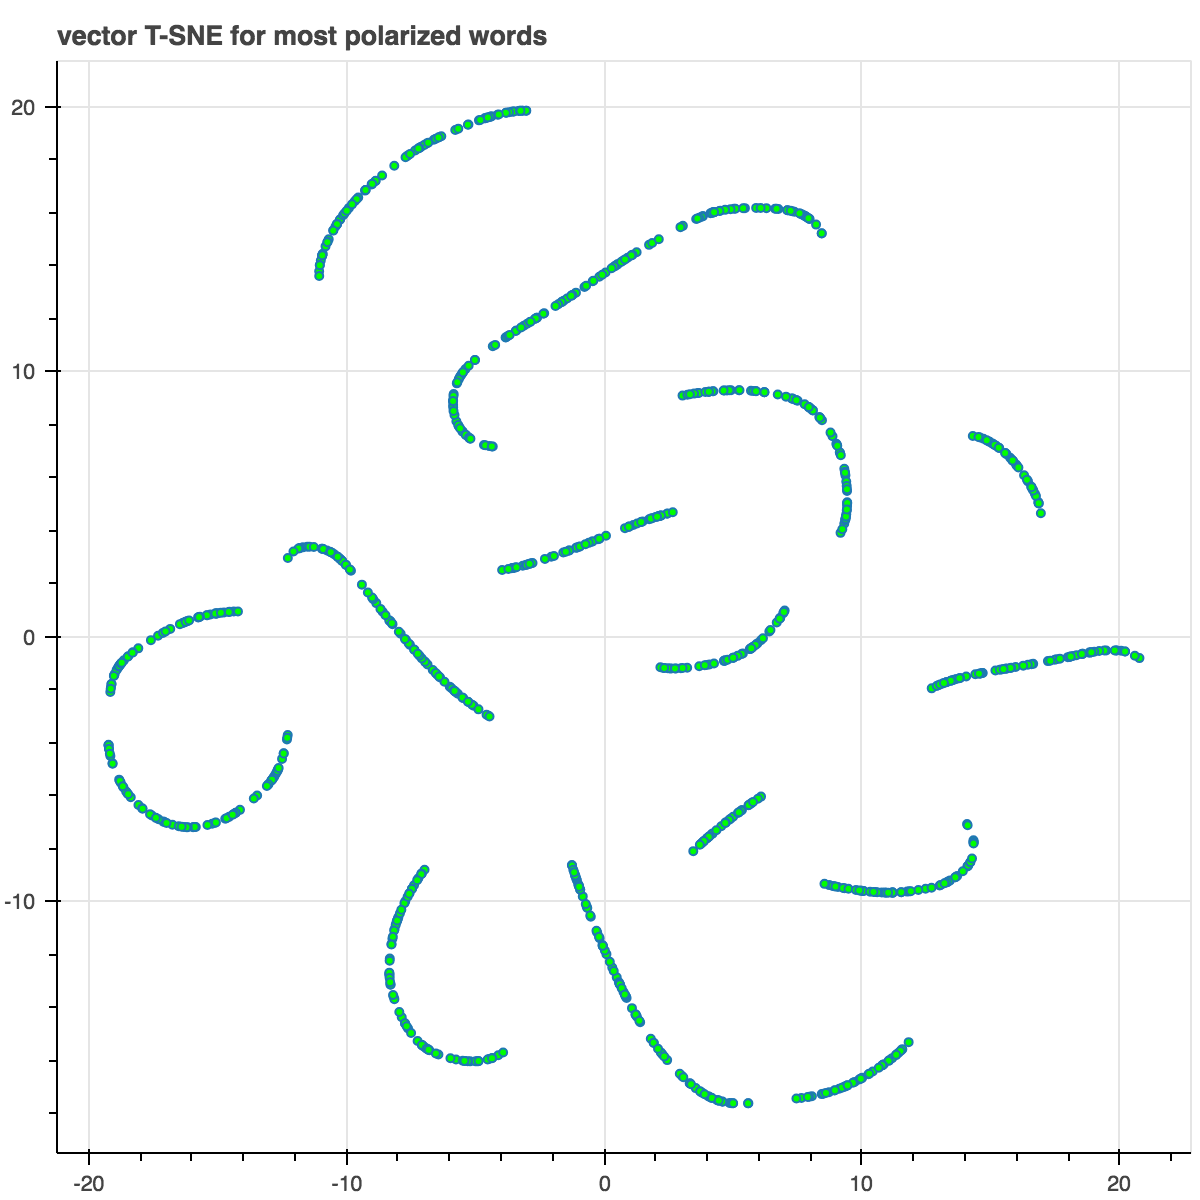

In [66]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="vector T-SNE for most polarized words")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=words_to_visualize,
                                    color=colors_list))
# output_file('output4.html')
p.scatter(x="x1", y="x2", size=4, source=source, fill_color="color")

word_labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
# p.add_layout(word_labels)

# show(p)

# green indicates positive words, black indicates negative words
Image(filename='bokeh_plot (1).png')